In [ ]:
!pip install snscrape
# # !pip install nltk
# !pip install matplotlib
# !pip install wordcloud
# !pip install textblob
# !pip insatall re
!pip install vaderSentiment

In [2]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
from textblob import TextBlob
import re
import numpy as np
from PIL import Image
import datetime as dt
import csv

In [ ]:
import nltk
nltk.download('stopwords') #run once 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [ ]:
#change
keyword = "Donald Trump"

# since_date = 2023-04-01
# until_date = 2023-04-03
# query = f'{keyword} since:{since_date} until:{until_date} lang:en'

query = keyword + " lang:en"

number_of_tweets_to_extract = 100000

tweets_with_loc = []

tweets = []

fr = open("/content/drive/MyDrive/dsci_project/temp/rejected_tweets_analysis.txt", "w")

for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):   
    if i>number_of_tweets_to_extract:
        break

    else:
        if(len(tweet.content.split()) >= 10): #why 10
            if str(tweet.user.location) != "" :
                tweets_with_loc.append(str(tweet.user.location))
            tweets.append([tweet.date, tweet.user.username, tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])
        else:
            fr.write(tweet.content + " " + str(len(tweet.content.split())) + "\n")


In [ ]:
# #change
# keyword = "Joe Biden"

# since_date = 2023-04-01
# until_date = 2023-04-03
# query = f'{keyword} since:{since_date} until:{until_date} lang:en'

# tweets_with_loc = []

# tweets = []

# fr = open("/content/drive/MyDrive/dsci_project/temp/rejected_tweets_analysis.txt", "w")

# for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):   
#     if(len(tweet.content.split()) >= 10): #why 10
#           if str(tweet.user.location) != "" :
#               tweets_with_loc.append(str(tweet.user.location))
#           tweets.append([tweet.date, tweet.user.username, tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])
#       else:
#           fr.write(tweet.content + " " + str(len(tweet.content.split())) + "\n")
  

In [5]:
df = pd.DataFrame(tweets, columns = ['date', 'username', 'source', 'location', 'tweet', 'num_of_likes', 'num_of_retweet'])
df.to_csv('/content/drive/MyDrive/dsci_project/temp/sentiment.csv')

# df = pd.read_csv('/content/drive/MyDrive/dsci_project/tweets_donald_trump.csv')
# number_of_tweets = len(df) + 1

In [ ]:
#graph1
hashtags = {}
# mentions = {}

def count_tags(tweet_text):
    hashtag = re.findall(r"#(\w+)", tweet_text)
    # mentions = re.findall(r"@(\w+)", tweet_text)
    
    if(len(hashtag)!=0):
        for i in hashtag: 
            if i not in hashtags.keys():
                hashtags[i] = 1
            else:
                hashtags[i] += 1    
        
        # for i in mention: 
        #     if i not in mentions.keys():
        #         mentions[i] = 1
        #     else:
        #         mentions[i] += 1   

df['tweet'].apply(count_tags)

hashtagslist = list(hashtags.keys())

for key in hashtagslist:
    if (hashtags[key] < 0.001 * number_of_tweets) or (hashtags[key] > 0.01 * number_of_tweets):
        del hashtags[key]

hashtagslist = list(hashtags.keys())
frequencies = list(hashtags.values())

plt.bar(range(len(hashtagslist)), frequencies, tick_label=hashtagslist)
plt.rcParams['figure.figsize'] = [40, 5]
plt.show()

In [9]:
def filtering(text):
    text = text.lower()

    #mentions, hashtags, any character except, urls?
    # text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())

    tokens = word_tokenize(text)  
  
    eng_stop_words = list(stopwords.words('english'))
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    # filtered_words = [w for w in filtered_words if w not in emoji]

    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)

    return text

In [14]:
def vader_polarity(text):
    score = sia().polarity_scores(text)
    compound_score = score['compound']

    return compound_score

def sentiment_count(text):
    compound_score = vader_polarity(text)

    if compound_score > 0 : pnn[0] += 1
    elif compound_score == 0 : pnn[1] += 1
    else : pnn[2] += 1   

In [ ]:
pnn = [0, 0, 0]
df['sentiment'] = df['filtered_tweets'].apply(sentiment_count)

In [17]:
# df.to_csv('/content/drive/MyDrive/dsci_project/tweets_with_sentiment.csv', mode = 'w')

df = pd.read_csv('/content/drive/MyDrive/dsci_project/tweets_with_sentiment.csv')

In [ ]:
#graph2
x_axis = ["positive", "neutral", "negative"]

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(x_axis, pnn)

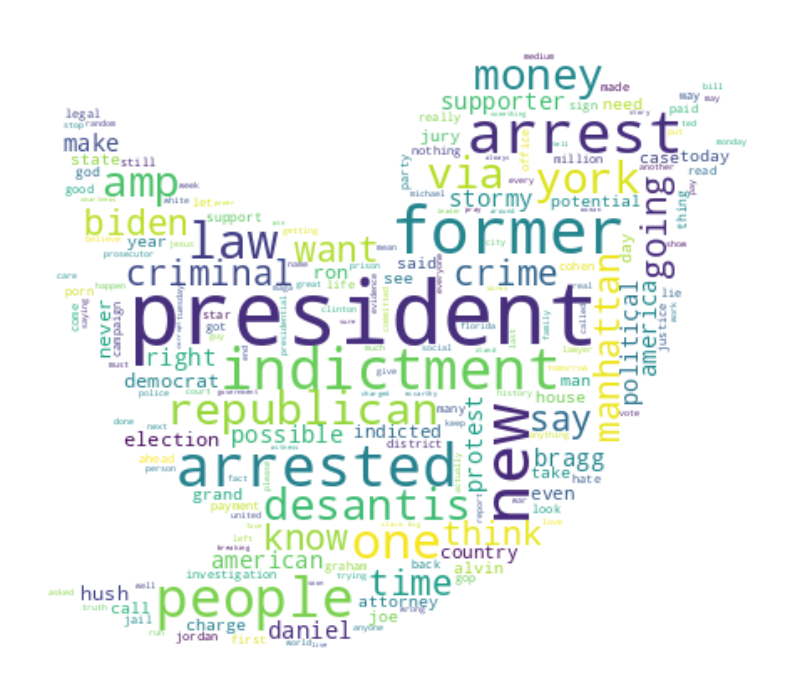

In [19]:
#graph3

tweets_string = df['filtered_tweets'].tolist()
tweets_string = " ".join(tweets_string)

tweets_string = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweets_string).split())

tweets_list = tweets_string.split()

#change
words_not_to_include = ["donald", "trump"]

tweets_list = [i for i in tweets_list if (i not in words_not_to_include and len(i)>2)]

tweets_string = " ".join(tweets_list)

mask = np.array(Image.open('/content/drive/MyDrive/dsci_project/tlogo.png'))

w_cloud = WordCloud(collocations = False, max_words=200, background_color = 'white', mask=mask).generate(tweets_string)
plt.figure( figsize=(10, 10) )
plt.imshow(w_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New York', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
stateCodes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
stateMapping = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NY': 'New York', 'NM': 'New Mexico', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT':  'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV':  'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

# print(len(states))

df = df.fillna(0)

no_of_tweets_with_state = 0

for index, row in df.iterrows():
  if row.location:
    locationSplit = row.location.split(',')
    for word in locationSplit:
      word_stripped = word.strip()
      if word_stripped in states:
        no_of_tweets_with_state += 1
        df.loc[index, 'state'] = word_stripped
      elif word_stripped in stateCodes:
        no_of_tweets_with_state += 1
        df.loc[index, 'state'] = stateMapping[word_stripped]

print("tweets with proper location = ", no_of_tweets_with_state, "(", int(no_of_tweets_with_state/number_of_tweets * 100), "% )")

# df.to_csv('/content/drive/MyDrive/dsci_project/tweets_with_polarity_and_location.csv', mode = 'w')

tweets with proper location =  5134 ( 28 % )


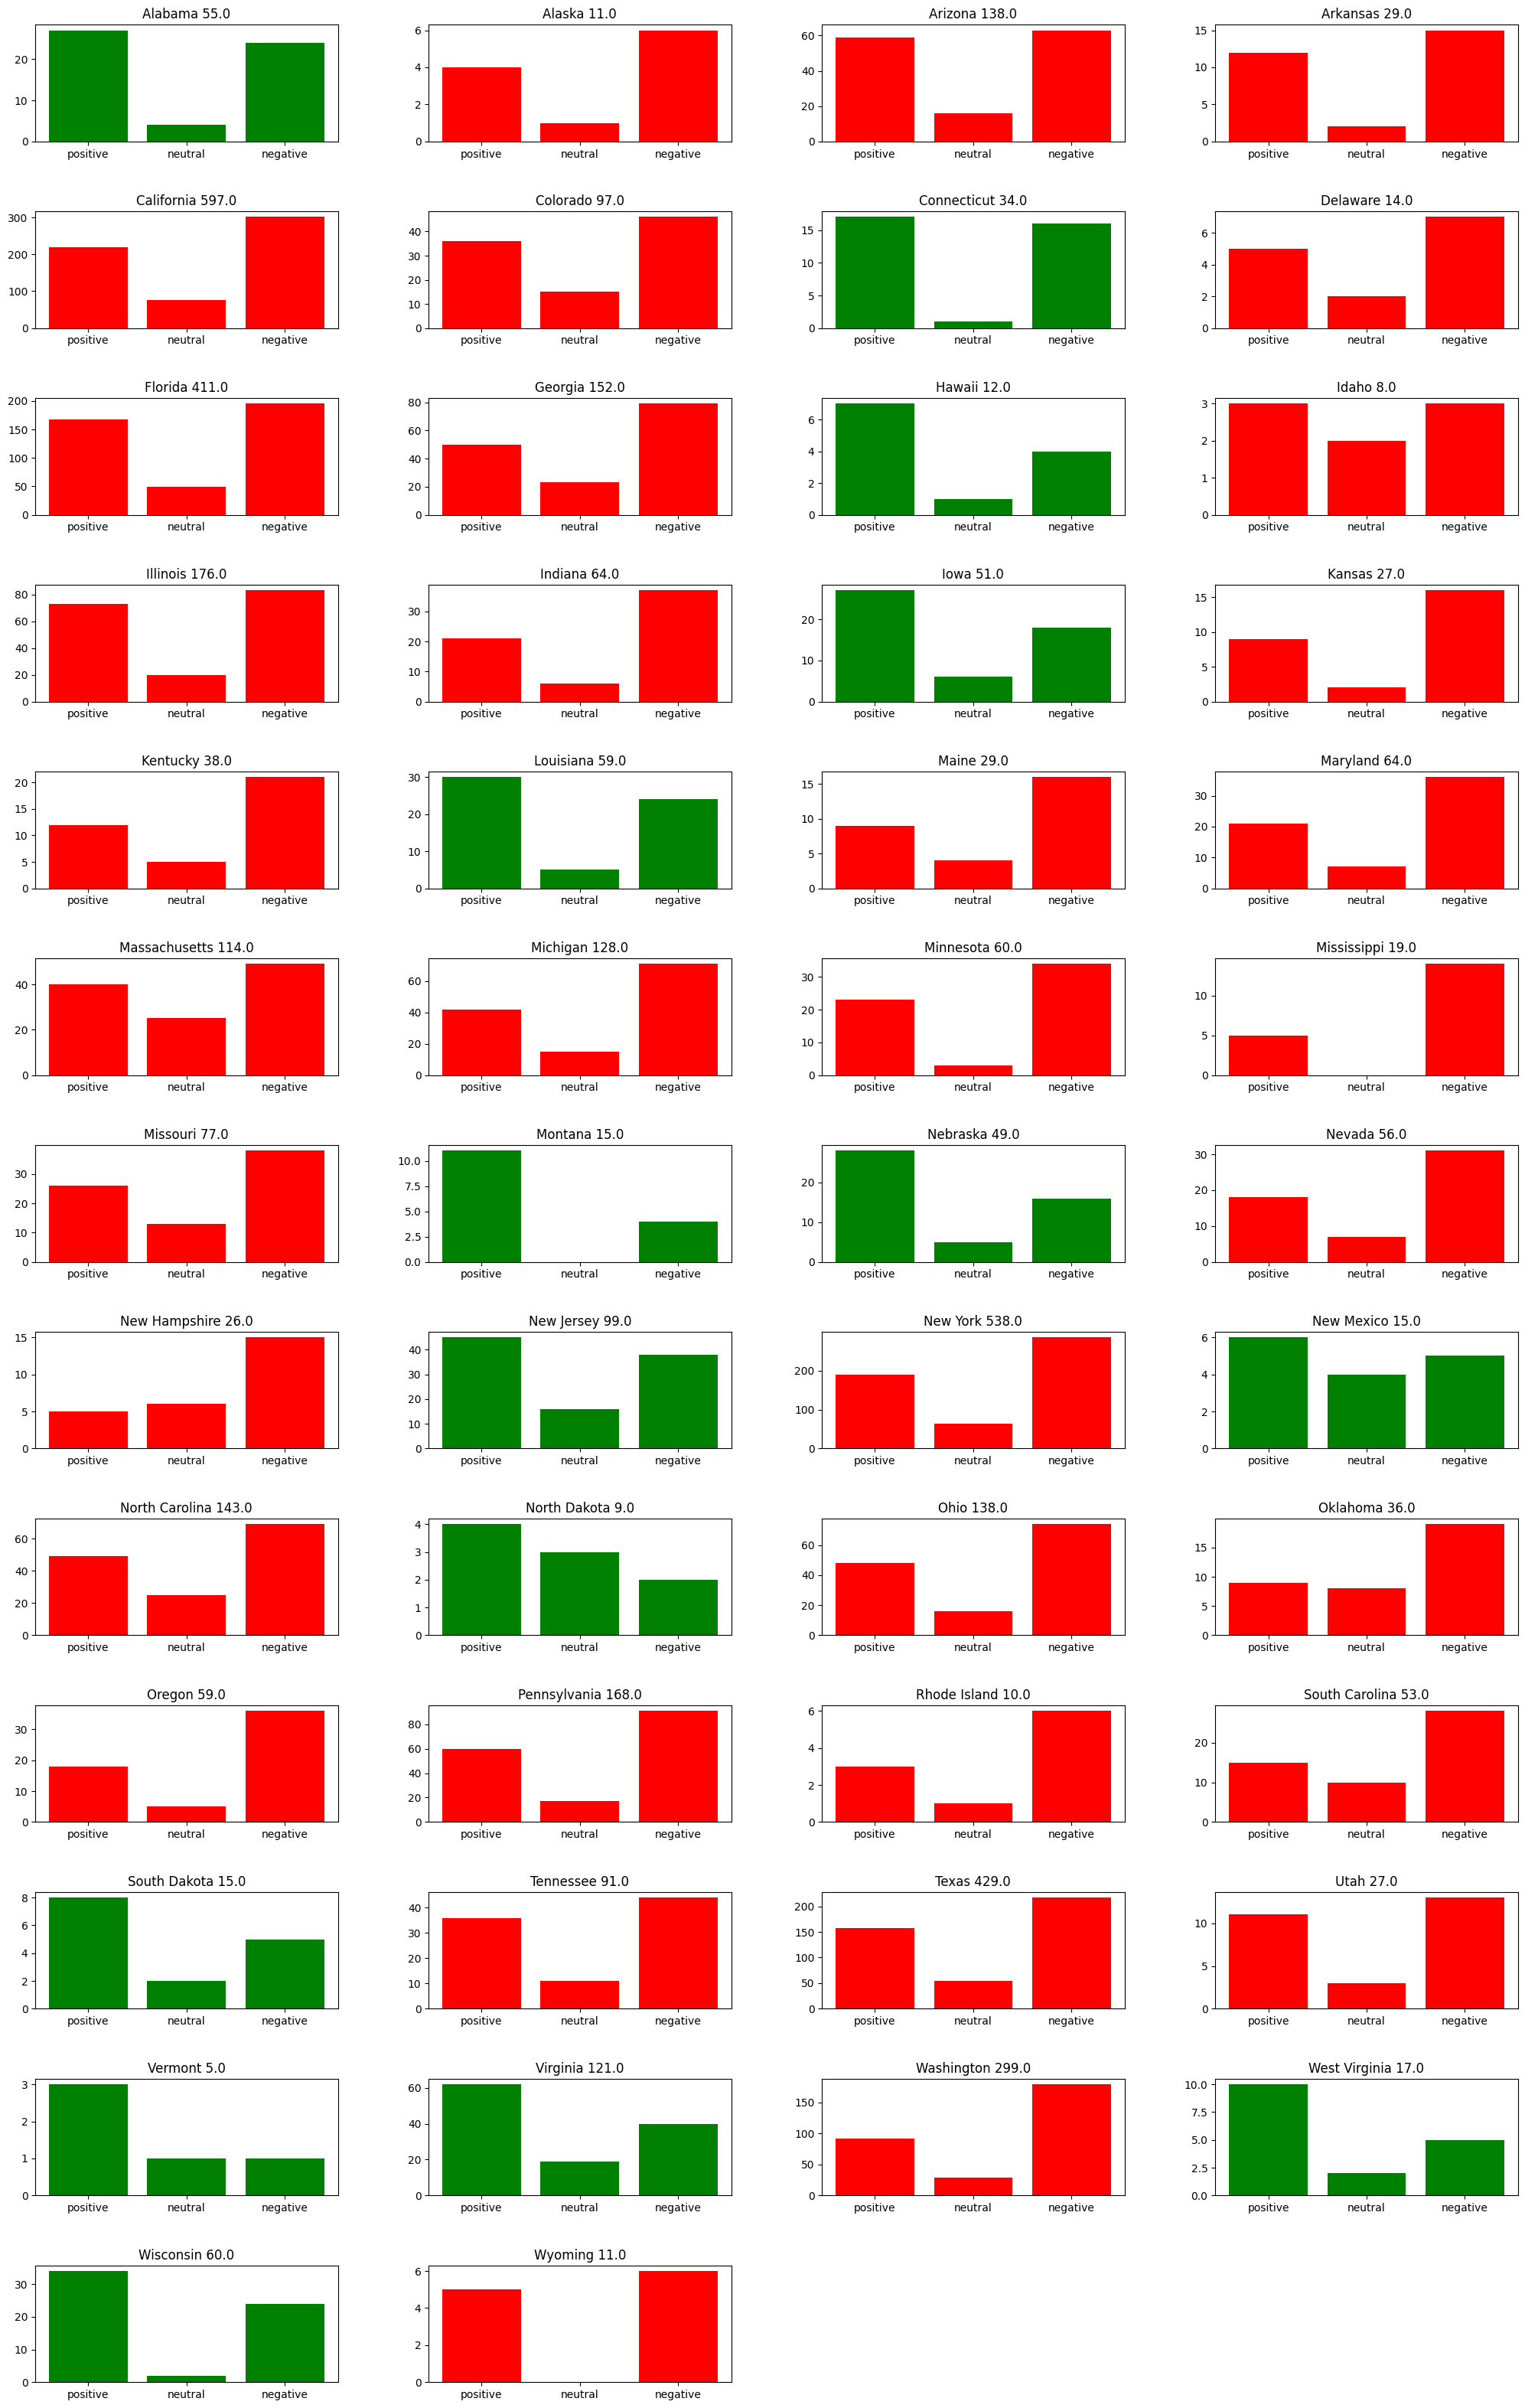

In [19]:
#graph4

df = pd.read_csv('/content/drive/MyDrive/dsci_project/tweets_with_sentiment_and_location.csv')

number_of_tweets = len(df) + 1
df = df.fillna(0)

arr = np.zeros((50, 3))

for index, row in df.iterrows():
  if row['state'] == "0" :
    continue
  
  sentiment = row['sentiment']

  if sentiment == "positive" : 
    arr[states.index(row['state'])][0] += 1
  elif sentiment == "neutral" : 
    arr[states.index(row['state'])][1] += 1
  else : 
    arr[states.index(row['state'])][2] += 1

plt.figure(figsize=(25,40))

x_axis = ["positive", "neutral", "negative"]

plt.subplots_adjust(wspace=0.3, hspace=0.6)

for i in range(50):
  plt.subplot(13, 4, i+1)
  plt.title(states[i] + " " + str(arr[i][0]+arr[i][1]+arr[i][2]))
  if(arr[i][0] > arr[i][2]) :
    color = 'green'
  else :
    color = 'red'
  plt.bar(x_axis, arr[i], color=color)
  
plt.show()

In [24]:
#daily analysis

def extract_yesterday_tweets(keyword):
    yesterday = dt.date.today() - dt.timedelta(days=1)
    since_date = yesterday.strftime('%Y-%m-%d')
    until_date = dt.date.today()

    search_query = f'{keyword} since:{since_date} until:{until_date} lang:en'

    yesterday_tweets = []

    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(search_query).get_items()):
        yesterday_tweets.append(tweet)
    return yesterday_tweets

In [29]:
#change
query = "Donald Trump"

yesterday_tweets = extract_yesterday_tweets(query)

eaf = open("/content/drive/MyDrive/dsci_project/everyday_analysis.csv", "a")

pnd = [0, 0]

for tweet in yesterday_tweets:
  tweet = filtering(tweet.content)
  compound_score = vader_polarity(tweet)

  if compound_score > 0 : pnd[0] += 1
  elif compound_score < 0 : pnd[1] += 1

a = int(pnd[0]*100 / len(yesterday_tweets))
b = int(pnd[1]*100 / len(yesterday_tweets))

yesterdays_date = dt.date.today() - dt.timedelta(days=1) 

writer = csv.writer(eaf)
writer.writerow([yesterdays_date, a, b])
eaf.close()

# ~11min

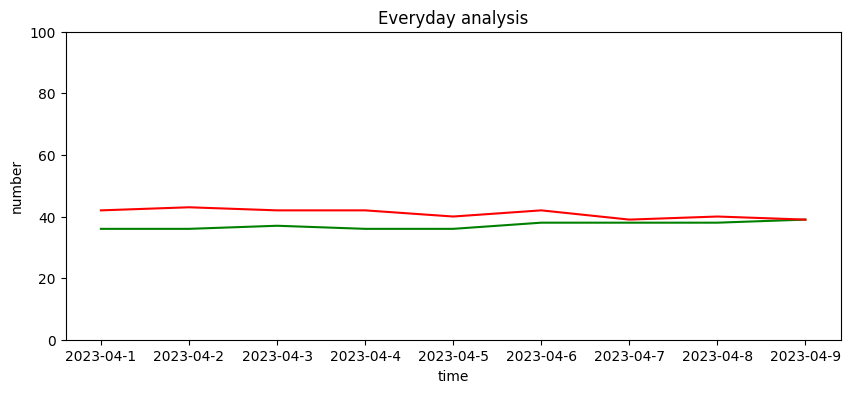

In [15]:
#graph5

data = pd.read_csv("/content/drive/MyDrive/dsci_project/everyday_analysis.csv")

plt.figure(figsize=(10,4))

plt.plot(data['date'], data['positive'], color="green")
plt.plot(data['date'], data['negative'], color="red")

plt.title('Everyday analysis')
plt.xlabel('time')
plt.ylabel('number')

plt.ylim([0, 100])

plt.show()